In [1]:
from google.colab import files
uploaded = files.upload()

# This moves the uploaded kaggle.json to the correct location
import os
import shutil

if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print("✅ kaggle.json uploaded and set up successfully.")
else:
    print("❌ kaggle.json not found. Please upload again.")


Saving kaggle.json to kaggle.json
✅ kaggle.json uploaded and set up successfully.


In [2]:
!kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset
!unzip -qo casia-20-image-tampering-detection-dataset.zip -d /content/casia


Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown


In [3]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from pathlib import Path

In [4]:
# Resize to 224x224 for DenseNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

In [5]:
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_path = Path('/content/casia/CASIA2')
au_path = base_path / 'Au'
tp_path = base_path / 'Tp'

# Output folders
output_base = Path('/content/data')
train_authentic = output_base / 'Train' / 'Authentic'
train_tampered = output_base / 'Train' / 'Tampered'
val_authentic = output_base / 'Validation' / 'Authentic'
val_tampered = output_base / 'Validation' / 'Tampered'

# Create directories
for path in [train_authentic, train_tampered, val_authentic, val_tampered]:
    path.mkdir(parents=True, exist_ok=True)

# Get file lists
au_files = list(au_path.glob('*.*'))
tp_files = list(tp_path.glob('*.*'))

# Split 80/20
au_train, au_val = train_test_split(au_files, test_size=0.2, random_state=42)
tp_train, tp_val = train_test_split(tp_files, test_size=0.2, random_state=42)

# Copy files
for f in au_train: shutil.copy(f, train_authentic / f.name)
for f in au_val: shutil.copy(f, val_authentic / f.name)
for f in tp_train: shutil.copy(f, train_tampered / f.name)
for f in tp_val: shutil.copy(f, val_tampered / f.name)

In [6]:
train_dir = output_base / 'Train'
val_dir = output_base / 'Validation'

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['Authentic', 'Tampered']


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 122MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        print(f"\n🔁 Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training
        progress_bar = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Progress bar description
            progress_bar.set_postfix({
                'Loss': f"{train_loss / total:.4f}",
                'Acc': f"{100 * correct / total:.2f}%"
            })

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"✅ Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100 * val_correct / val_total
        print(f"🔎 Validation Acc: {val_acc:.2f}%")

In [12]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)


🔁 Epoch 1/5


✅ Train Loss: 0.5241 | Train Acc: 73.32%
🔎 Validation Acc: 77.22%

🔁 Epoch 2/5


✅ Train Loss: 0.3930 | Train Acc: 81.30%
🔎 Validation Acc: 77.38%

🔁 Epoch 3/5


✅ Train Loss: 0.3503 | Train Acc: 83.26%
🔎 Validation Acc: 79.99%

🔁 Epoch 4/5


✅ Train Loss: 0.3234 | Train Acc: 84.42%
🔎 Validation Acc: 78.41%

🔁 Epoch 5/5


✅ Train Loss: 0.3082 | Train Acc: 85.15%
🔎 Validation Acc: 76.19%


In [13]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r--', label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'g--', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

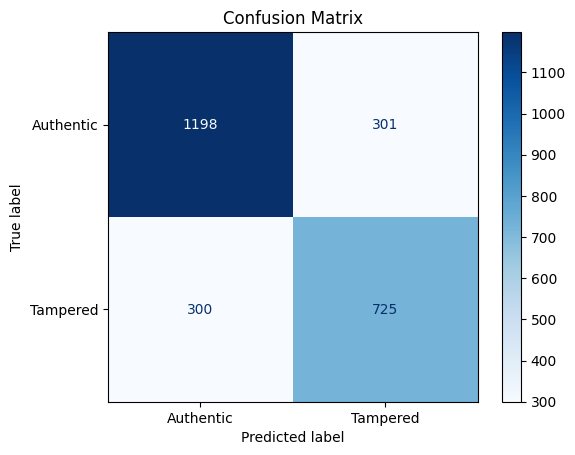

In [15]:
plot_confusion_matrix(model, val_loader, class_names=['Authentic', 'Tampered'])

In [22]:
!pip install scikit-learn matplotlib seaborn

In [23]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
from torchvision import transforms

def visualize_all(model, dataloader, class_names=['Authentic', 'Tampered'], device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    probs = []
    confidences = []
    misclassified = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            prob = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())  # Class 1 = Tampered
            confidences.extend(prob.max(dim=1)[0].cpu().numpy())

            # Collect misclassified
            for img, pred, label in zip(inputs.cpu(), preds.cpu(), labels.cpu()):
                if pred != label:
                    misclassified.append((img, pred, label))
            if len(misclassified) >= 5:
                break

    # 1. Classification Report
    print("📋 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # 3. Confidence Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(confidences, bins=20, kde=True, color='skyblue')
    plt.xlabel("Model Confidence")
    plt.title("Prediction Confidence Histogram")
    plt.grid()
    plt.show()

    # 4. Misclassified Images
    if misclassified:
        print(f"🔍 Showing {min(5, len(misclassified))} misclassified samples")
        plt.figure(figsize=(15, 5))
        for i, (img, pred, label) in enumerate(misclassified[:5]):
            plt.subplot(1, 5, i + 1)
            img = img.permute(1, 2, 0)
            img = torch.clamp(img, 0, 1)
            plt.imshow(img)
            plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("✅ No misclassified samples in this batch!")

📋 Classification Report:

              precision    recall  f1-score   support

   Authentic       1.00      0.50      0.67        32
    Tampered       0.00      0.00      0.00         0

    accuracy                           0.50        32
   macro avg       0.50      0.25      0.33        32
weighted avg       1.00      0.50      0.67        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188:

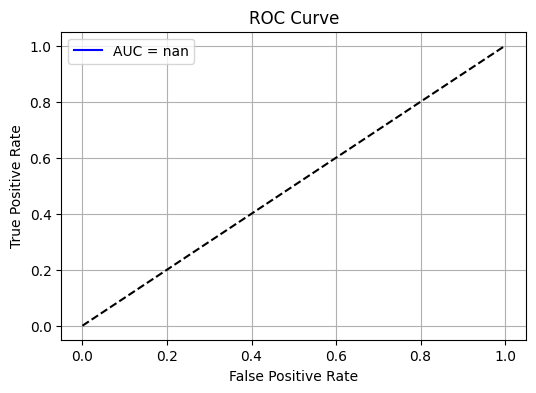

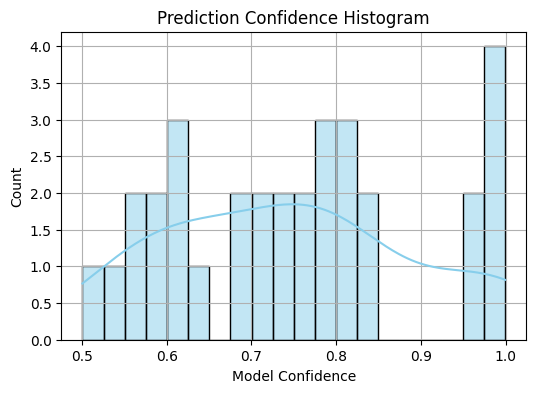

🔍 Showing 5 misclassified samples


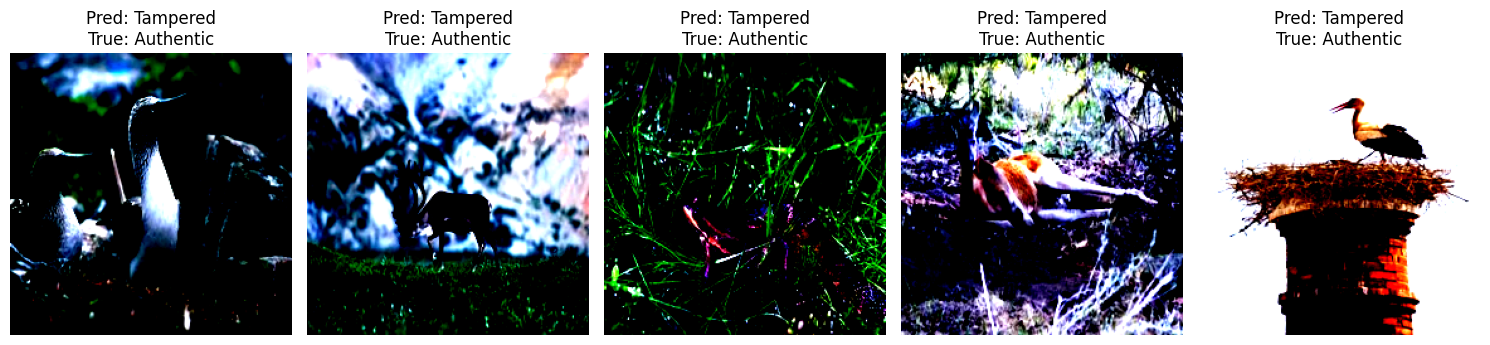

In [24]:
visualize_all(model, val_loader, class_names=['Authentic', 'Tampered'], device=device)

In [25]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 826.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 390.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 919.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 832.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.9 MB/

In [30]:
!pip install -q git+https://github.com/jacobgil/pytorch-grad-cam.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Helper: Get the last convolutional layer for DenseNet121
def get_target_layer(model):
    return model.features.denseblock4.denselayer16.conv2

# Helper: Visualize GradCAM on a few validation images
def visualize_gradcam(model, dataloader, device, num_images=5, class_names=["Authentic", "Tampered"]):
    model.eval()
    target_layer = get_target_layer(model)

    images_shown = 0

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            for i in range(inputs.size(0)):
                input_tensor = inputs[i].unsqueeze(0)
                rgb_img = input_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
                rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

                grayscale_cam = cam(input_tensor=input_tensor)[0]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                plt.figure(figsize=(8, 4))
                plt.suptitle(f"True: {class_names[labels[i].item()]}", fontsize=12)

                plt.subplot(1, 2, 1)
                plt.imshow(rgb_img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(visualization)
                plt.title("GradCAM")
                plt.axis('off')

                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

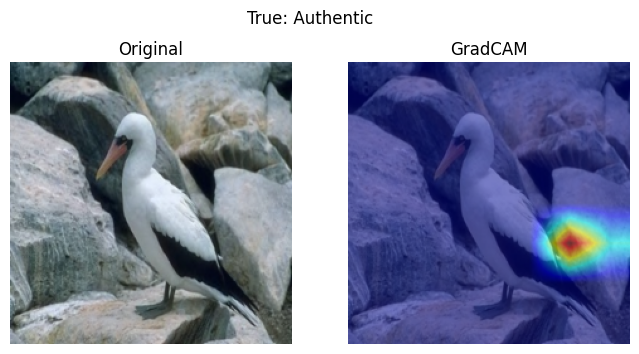

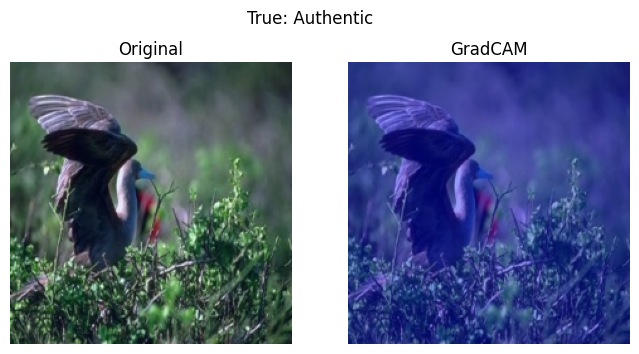

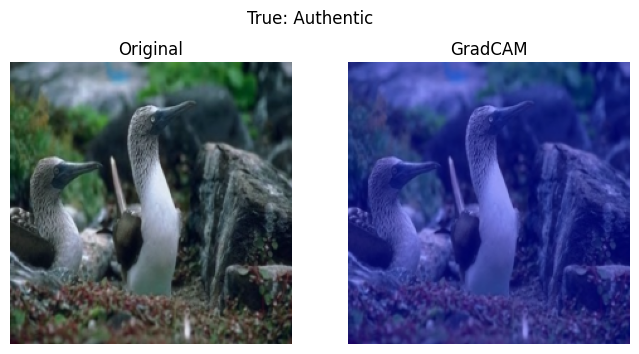

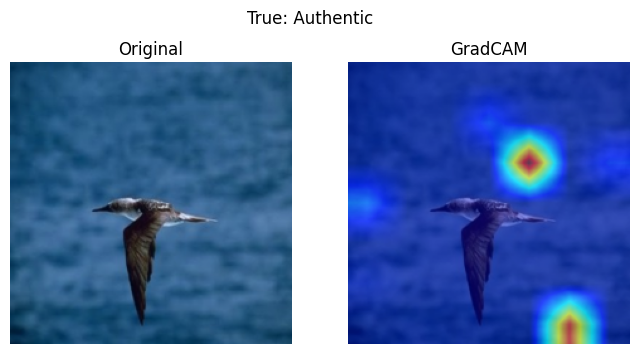

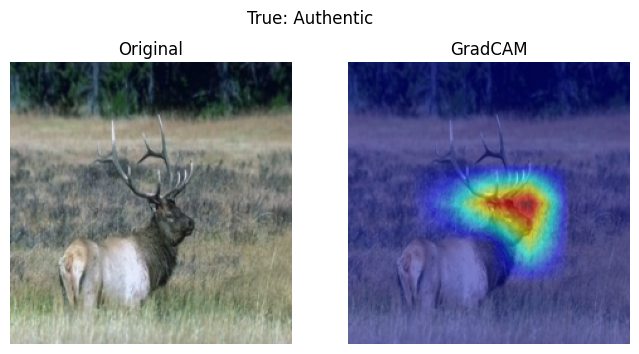

In [32]:
visualize_gradcam(model, val_loader, device=device, num_images=5)

In [33]:
import os
from pytorch_grad_cam import GradCAMPlusPlus
from torchvision.utils import save_image
from datetime import datetime

def visualize_and_save_gradcam(model, dataloader, device, output_dir="gradcam_outputs", num_images=5, class_names=["Authentic", "Tampered"]):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    target_layer = get_target_layer(model)

    with GradCAMPlusPlus(model=model, target_layers=[target_layer]) as cam:
        shown = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                input_tensor = inputs[i].unsqueeze(0)
                rgb_img = input_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
                rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

                grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                # Plot
                plt.figure(figsize=(10, 4))
                plt.suptitle(f"True: {class_names[labels[i]]}, Predicted: {class_names[preds[i]]}", fontsize=12)

                plt.subplot(1, 2, 1)
                plt.imshow(rgb_img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(visualization)
                plt.title("GradCAM++")
                plt.axis('off')

                # Save image
                filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}_{i}_true-{class_names[labels[i]]}_pred-{class_names[preds[i]]}.png"
                plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return

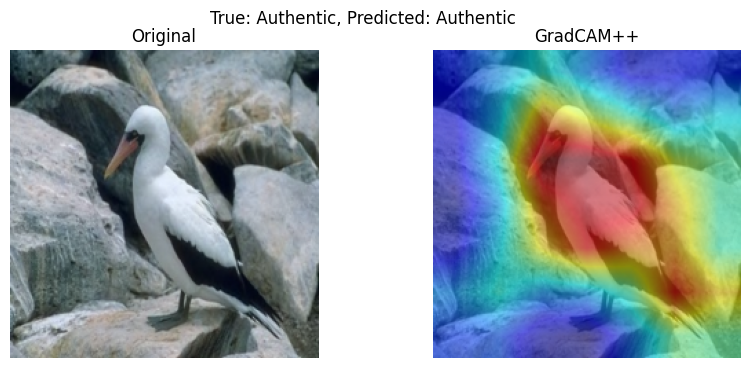

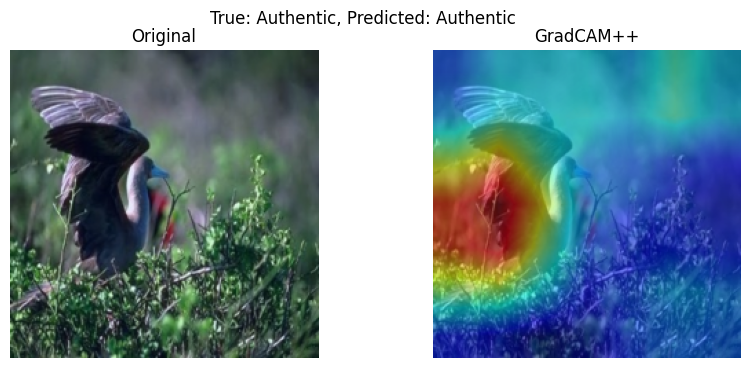

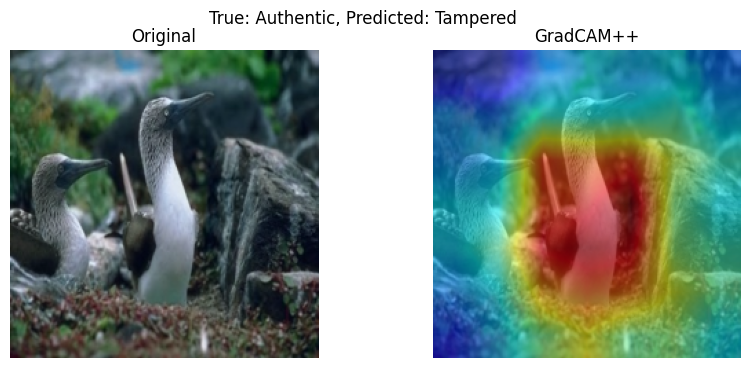

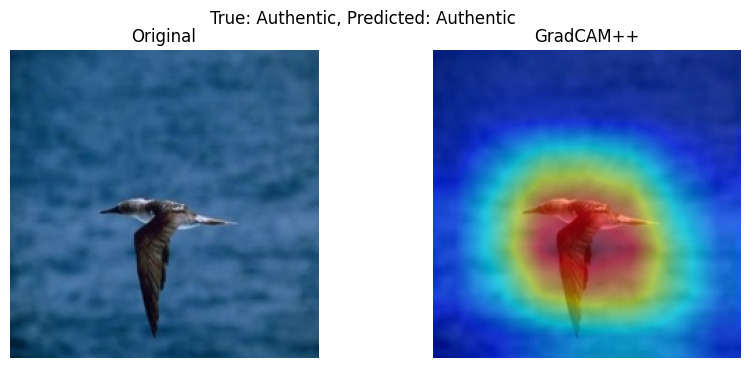

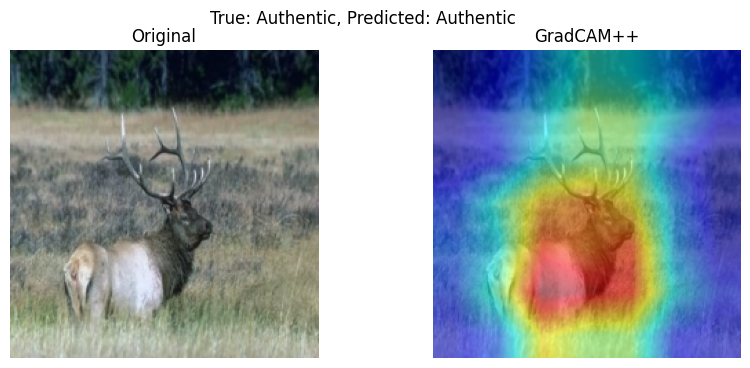

In [34]:
visualize_and_save_gradcam(model, val_loader, device=device, num_images=5)

In [40]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_auc_and_precision_recall(model, dataloader, device, class_names=["Authentic", "Tampered"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # One-hot encode the labels
    y_true = label_binarize(all_labels, classes=[0, 1])

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_true.ravel(), all_preds[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), all_preds[:, 1])
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

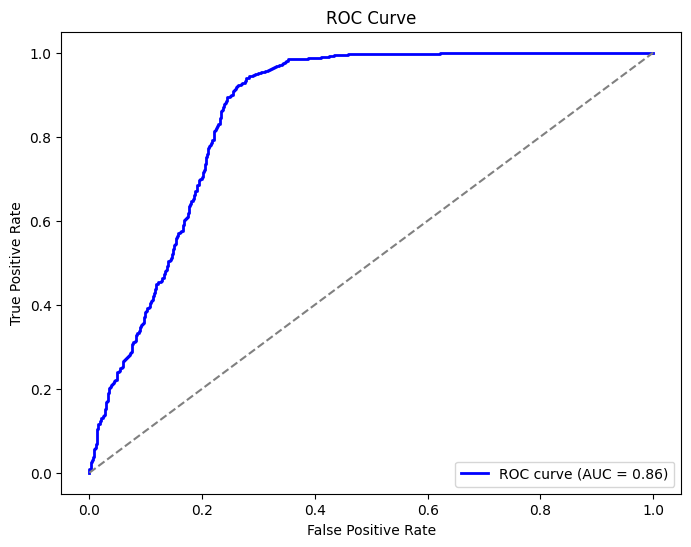

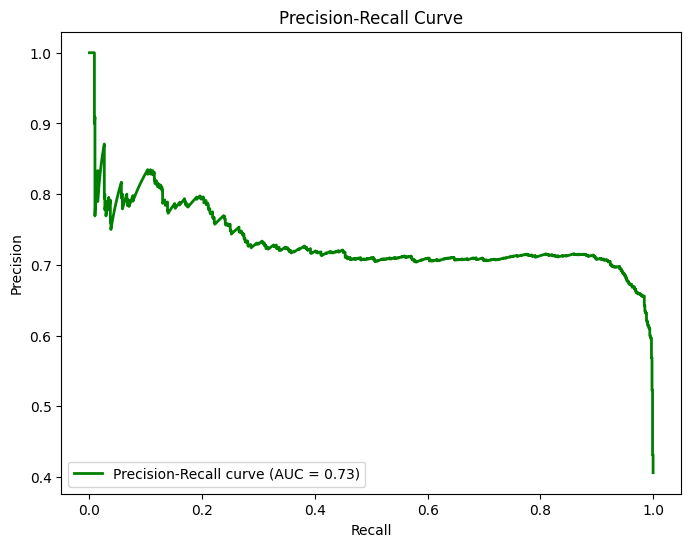

In [41]:
plot_roc_auc_and_precision_recall(model, val_loader, device, class_names=["Authentic", "Tampered"])